<a href="https://colab.research.google.com/github/bhargavitadala/iwild/blob/main/iwild_YoloV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16495, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 16495 (delta 30), reused 36 (delta 9), pack-reused 16408
Receiving objects: 100% (16495/16495), 15.11 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (11295/11295), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
dataset="/content/drive/MyDrive/iWild"

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset}/data.yaml

names:
- empty
- tayassu pecari
- dasyprocta punctata
- cuniculus paca
- puma concolor
- tapirus terrestris
- pecari tajacu
- mazama americana
- leopardus pardalis
- geotrygon montana
- nasua nasua
- dasypus novemcinctus
- eira barbara
- didelphis marsupialis
- procyon cancrivorus
- panthera onca
- myrmecophaga tridactyla
- tinamus major
- sylvilagus brasiliensis
- puma yagouaroundi
- leopardus wiedii
- mazama gouazoubira
- philander opossum
- capra aegagrus
- bos taurus
- ovis aries
- canis lupus
- lepus saxatilis
- turtur calcospilos
- papio anubis
- genetta genetta
- tragelaphus scriptus
- equus africanus
- herpestes sanguineus
- loxodonta africana
- cricetomys gambianus
- raphicerus campestris
- hyaena hyaena
- aepyceros melampus
- crocuta crocuta
- caracal caracal
- equus ferus
- panthera leo
- tragelaphus oryx
- kobus ellipsiprymnus
- phacochoerus africanus
- panthera pardus
- ichneumia albicauda
- canis mesomelas
- syncerus caffer
- equus quagga
- giraffa camelopardalis
- alcela

In [ ]:
cd /content/drive/MyDrive/iWild

/content/drive/MyDrive/iWild


In [ ]:
#!unzip /content/drive/MyDrive/iWild/animals.zip

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data {dataset}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-04-08 15:29:21.700843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 15:29:21.700895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 15:29:21.802599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 15:29:22.845342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/drive/MyDrive/iWild/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, no

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

FileNotFoundError: [Errno 2] No such file or directory: '/content/yolov5/runs/train/yolov5s_results2/results.png'

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

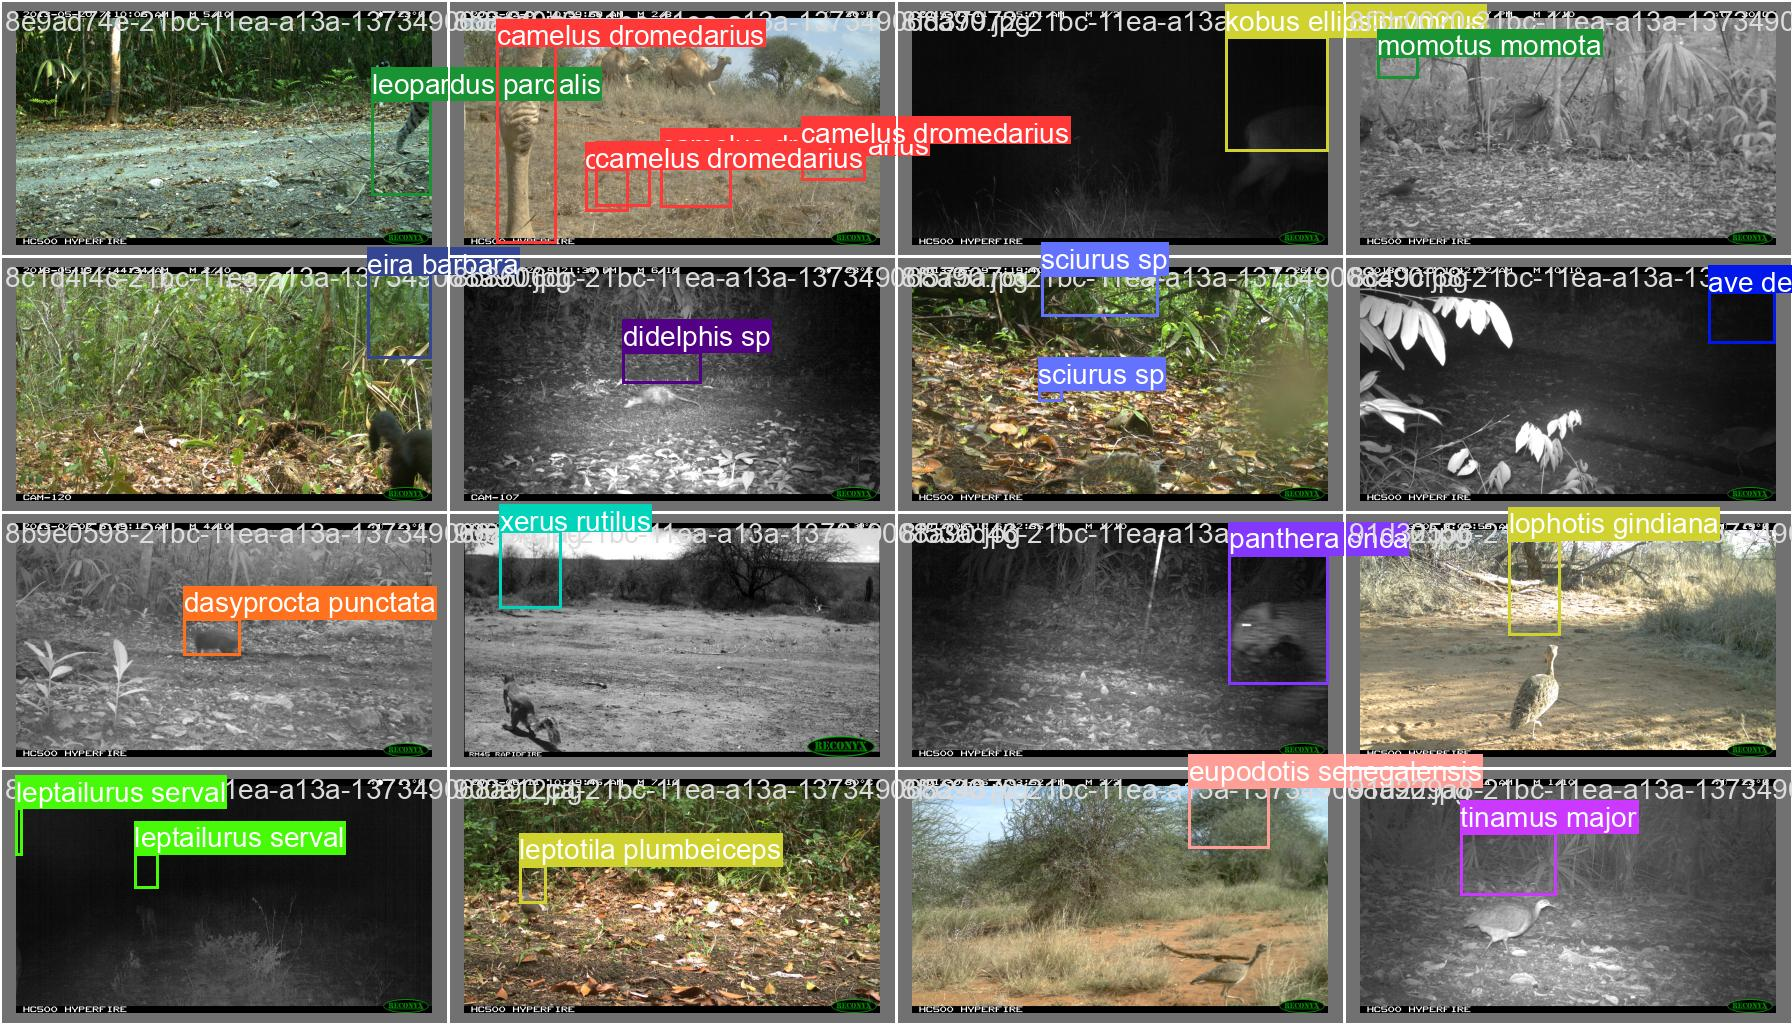

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


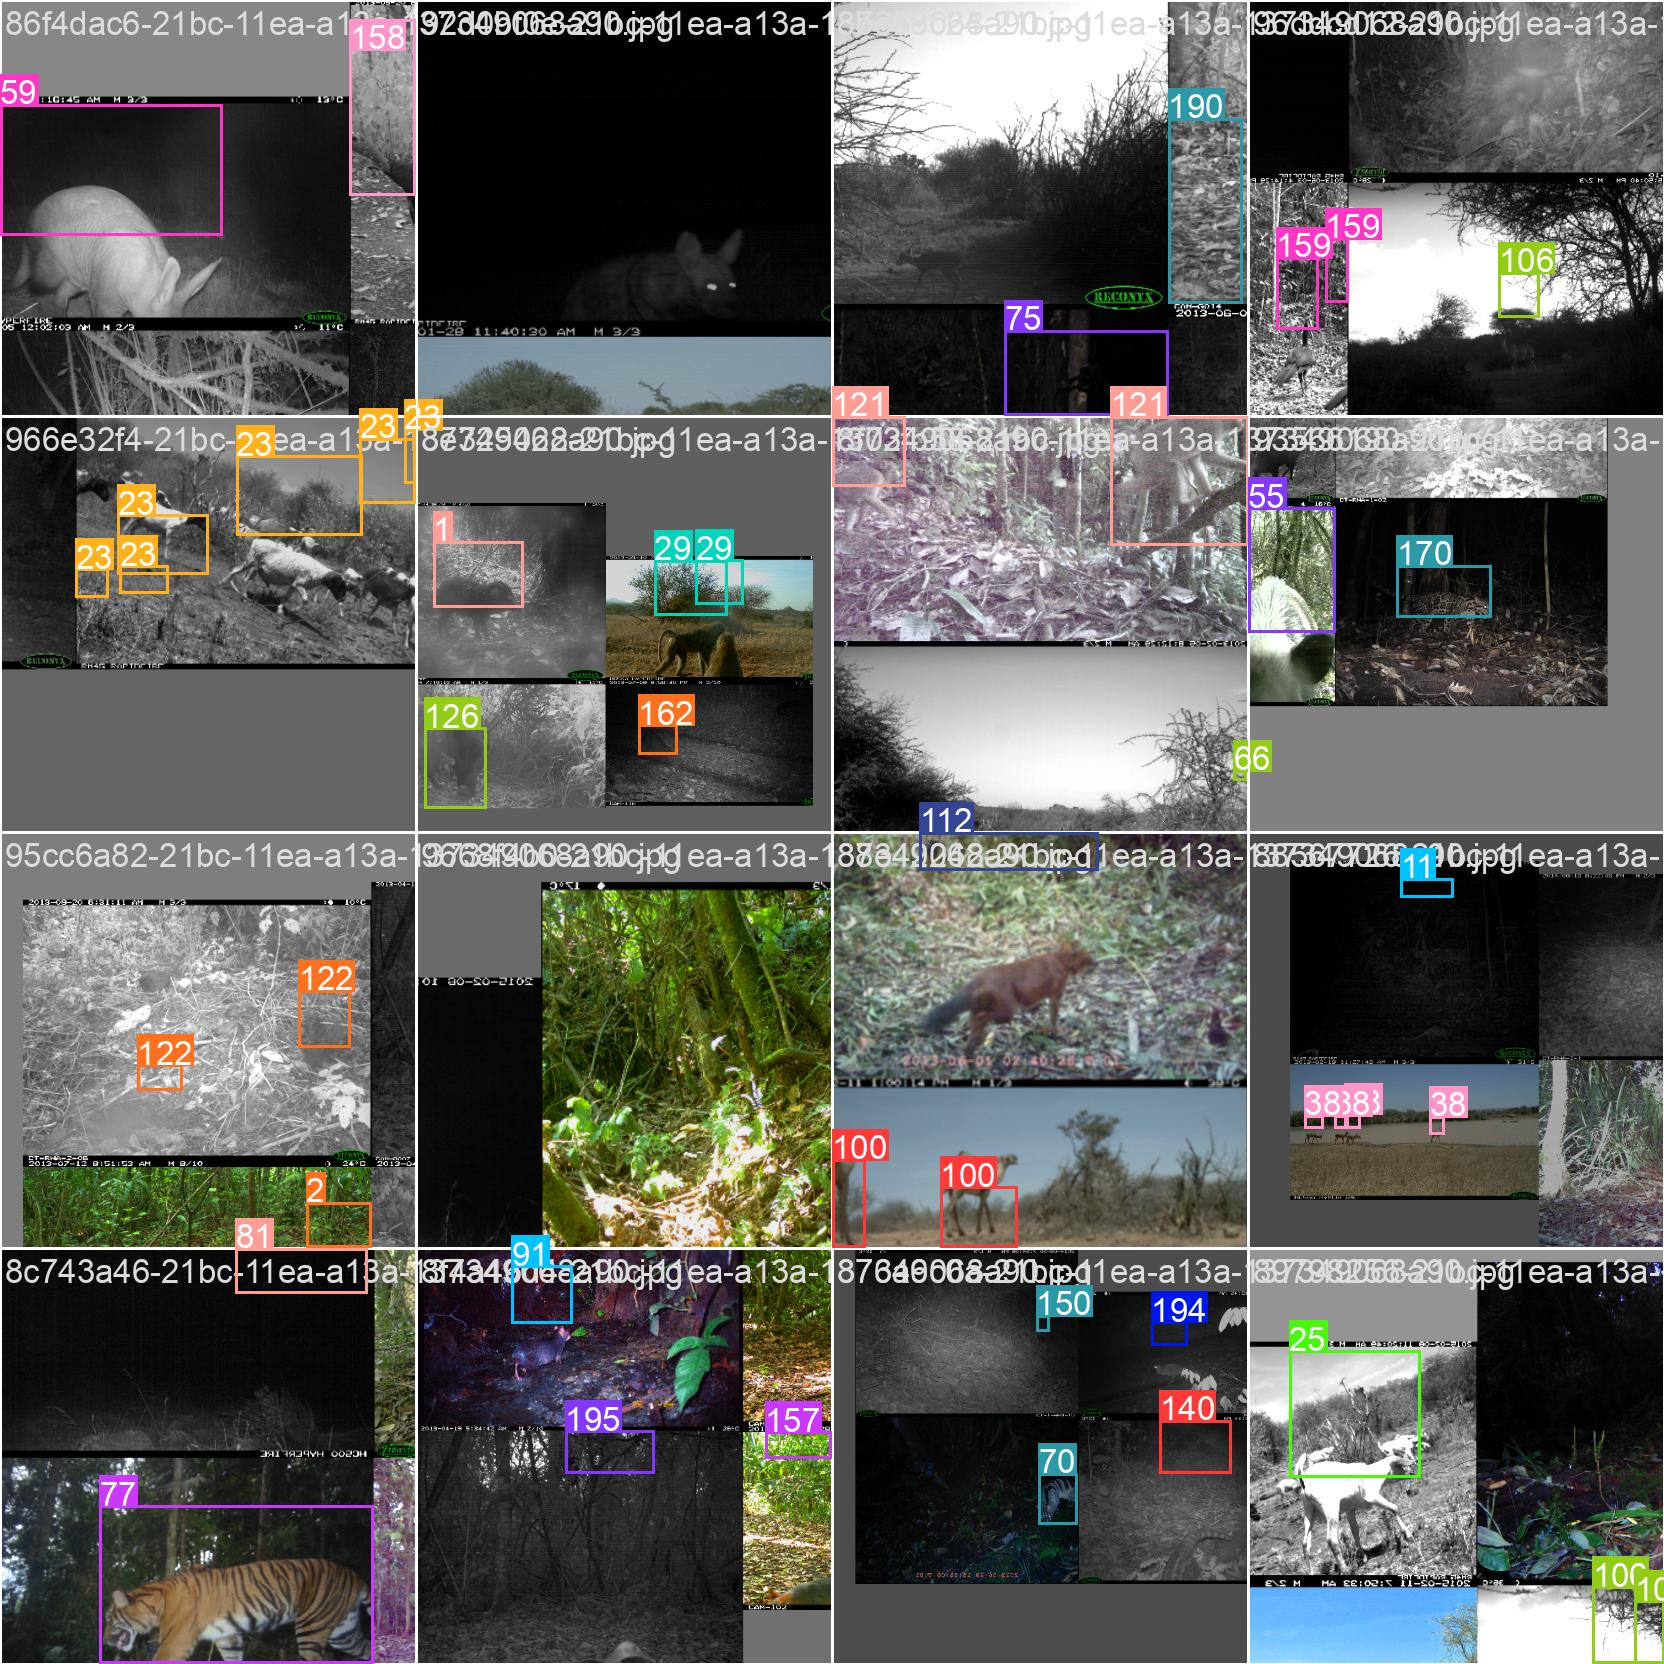

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

In the snippet below, replace `Cash-Counter-10` with the name of the folder in which your dataset is stored.

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source Cash-Counter-10/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=Cash-Counter-10/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7777827 parameters, 0 gradients
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 261, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 256, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, *

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

In [ ]:
!zip -r /content/runs.zip /content/yolov5/runs

  adding: content/yolov5/runs/ (stored 0%)
  adding: content/yolov5/runs/train/ (stored 0%)
  adding: content/yolov5/runs/train/yolov5s_results2/ (stored 0%)
  adding: content/yolov5/runs/train/yolov5s_results2/results.csv (deflated 83%)
  adding: content/yolov5/runs/train/yolov5s_results2/PR_curve.png (deflated 15%)
  adding: content/yolov5/runs/train/yolov5s_results2/weights/ (stored 0%)
  adding: content/yolov5/runs/train/yolov5s_results2/weights/best.pt (deflated 10%)
  adding: content/yolov5/runs/train/yolov5s_results2/weights/last.pt (deflated 10%)
  adding: content/yolov5/runs/train/yolov5s_results2/hyp.yaml (deflated 45%)
  adding: content/yolov5/runs/train/yolov5s_results2/opt.yaml (deflated 49%)
  adding: content/yolov5/runs/train/yolov5s_results2/confusion_matrix.png (deflated 29%)
  adding: content/yolov5/runs/train/yolov5s_results2/val_batch1_labels.jpg (deflated 11%)
  adding: content/yolov5/runs/train/yolov5s_results2/labels.jpg (deflated 25%)
  adding: content/yolov5/ru

In [ ]:
cd /content/drive/MyDrive/iWild/

/content/drive/MyDrive/iWild


In [ ]:
!unzip /content/drive/MyDrive/iWild/runs.zip

Archive:  /content/drive/MyDrive/iWild/runs.zip
   creating: content/yolov5/runs/
   creating: content/yolov5/runs/train/
   creating: content/yolov5/runs/train/yolov5s_results2/
  inflating: content/yolov5/runs/train/yolov5s_results2/results.csv  
  inflating: content/yolov5/runs/train/yolov5s_results2/PR_curve.png  
   creating: content/yolov5/runs/train/yolov5s_results2/weights/
  inflating: content/yolov5/runs/train/yolov5s_results2/weights/best.pt  
  inflating: content/yolov5/runs/train/yolov5s_results2/weights/last.pt  
  inflating: content/yolov5/runs/train/yolov5s_results2/hyp.yaml  
  inflating: content/yolov5/runs/train/yolov5s_results2/opt.yaml  
  inflating: content/yolov5/runs/train/yolov5s_results2/confusion_matrix.png  
  inflating: content/yolov5/runs/train/yolov5s_results2/val_batch1_labels.jpg  
  inflating: content/yolov5/runs/train/yolov5s_results2/labels.jpg  
  inflating: content/yolov5/runs/train/yolov5s_results2/results.png  
  inflating: content/yolov5/runs/tr